<a href="https://colab.research.google.com/github/SunwungLee/reproduction/blob/master/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow import keras
from keras.datasets import mnist
from keras.datasets import cifar10
from torch import optim
import imgaug.augmenters as iaa
from torch import nn
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np

SET_MNIST, SET_CIFAR, SET_NORB = 0,1,2

Using TensorFlow backend.


In [0]:
def translate(X, x_mag_aug, y_mag_aug):
  result = iaa.Affine(translate_px={"x": (x_mag_aug, x_mag_aug), "y": (y_mag_aug, y_mag_aug)})
  seq = iaa.Sequential(result)
  images_aug = seq(images=X)
  return images_aug

def crop(X, mg_aug):
  result = iaa.Crop(px=tuple((mg_aug, mg_aug) for i in range(4)),
                    sample_independently=True,
                    keep_size=True)
  seq = iaa.Sequential(result)
  images_aug = seq(images=X)
  return images_aug

def rotate(X, mg_aug):
  result = iaa.Affine(rotate=(mg_aug, mg_aug))
  seq = iaa.Sequential(result)
  images_aug = seq(images=X)
  return images_aug

In [0]:
def load_dataset(SET_):
	if SET_ == SET_CIFAR:
		(trainX, trainY), (testX, testY) = cifar10.load_data()
		classes=(0,1)

	elif SET_ == SET_MNIST:
		(trainX, trainY), (testX, testY) = MNIST.load_data()
		classes=(3,8)

	trainY = trainY.flatten()
	mask = np.zeros(len(trainY), dtype=np.bool)
	for c in classes:
		mask |= (trainY == c)
		trainX_sub = trainX[mask]
		trainY_sub = trainY
		trainY_sub[mask & (trainY == classes[0])] = 0
		trainY_sub[mask & (trainY == classes[1])] = 1
		trainY_sub = trainY_sub[mask]

	testY = testY.flatten()
	mask = np.zeros(len(testY), dtype=np.bool)
	for c in classes:
		mask |= (testY == c)
		testX_sub = testX[mask]
		testY_sub = testY
		testY_sub[mask & (testY == classes[0])] = 0
		testY_sub[mask & (testY == classes[1])] = 1
		testY_sub = testY_sub[mask]
	#print(trainY_sub)
	trainY_sub = to_categorical(trainY_sub)
	testY_sub = to_categorical(testY_sub)

	#print(trainY_sub)

	return trainX_sub, trainY_sub, testX_sub, testY_sub


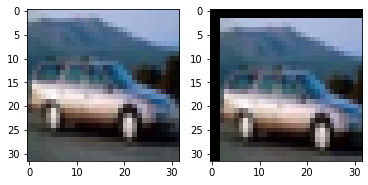

In [0]:
import matplotlib.pyplot as plt

trainX, trainY, testX, testY = load_dataset(SET_CIFAR)

f, ax = plt.subplots(1,2)

tmp = translate(trainX, 2,2)

ax[0].imshow(trainX[0])
ax[1].imshow(tmp[0])


In [0]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:


if learn_model == 1:
  input_shape = trainX.shape[1:]
  print(input_shape)
  model = None
  model = resnet_v2(input_shape, 56, 2)
  print(trainY.shape)
  model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
  model.summary()
  model.fit(trainX, trainY, validation_data=(testX, testY)) # original paper 128
  scores = model.evaluate(testX, testY)
  print('Test loss; ', scores[0])
  print('Test accuracy; ', scores[1])

  model.save('model.h5')


(32, 32, 3)












(10000, 2)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_______________________________________________________

2000/2000 [==============================] - 47s 23ms/step
Test loss;  1.0212062225341796
Test accuracy;  0.8325


In [0]:
import sklearn 
import sklearn.linear_model
import sklearn.pipeline

clf = sklearn.linear_model.LogisticRegression(max_iter=1000)
newmodel = Model(model.inputs, model.layers[-2].output)
print("pass2")
clf.fit(newmodel.predict(trainX), trainY.argmax(1))
print("pass")
print(clf.score(newmodel.predict(testX), testY.argmax(1)))

pass2
pass
0.929


In [0]:
import math
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

loss = np.zeros(trainX.shape[0])
print('#: ', trainX.shape[0])

for i in range(trainX.shape[0]):
  y = trainY.argmax(1)[i] 
  s = sigmoid(np.dot(newmodel.predict(trainX[i:i+1]), clf.coef_.T))
  loss[i] = -1 * (y*math.log(s)) + (1-y)*math.log(1-s)
  #loss[i] = (sigmoid(np.dot(newmodel.predict(trainX[i:i+1]), clf.coef_.T)) - trainY.argmax(1)[i]) ** 2

print(loss.shape)
print(loss)

#:  10000


In [11]:
#print(sigmoid(np.dot(newmodel.predict(trainX[i:i+1]), clf.coef_.T)).shape)
#print(newmodel.predict(trainX[:1]).shape)
print(trainY.argmax(1).shape)
print(loss)
print(clf.coef_.T.shape)

(10000,)
[1.06639673e-06 1.11245269e-08 1.53965168e-01 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
(256, 1)


In [0]:
import numpy as np 
x = newmodel.predict(trainX)
n = x.shape
hess = np.dot(x.T,x)
for i in range(n):
  
  pred = np.dot(x[i], clf.coef_.T)
  y = trainY.argmax(1)[i]

  
  gradient = np.dot(x.T, (pred-y))
  influence[i] = np.dot(np.dot(gradient.T, np.linalg.inv(hess)), gradient)



In [0]:
n = x.shape[0]
hess = np.dot(x.T,x)

influence = np.zeros(n)
for i in range(n):  
  rx = x[i].reshape(256,-1)
  pred = np.dot(rx, clf.coef_)
  y = trainY.argmax(1)[i]
 
  gradient = np.dot(rx.T, (pred-y))
  influence[i] = np.dot(np.dot(gradient, np.linalg.inv(hess)), gradient.T)

print('x', x.shape) # 10,000 x 256
print('hess',hess.shape) # 256 x 256
print('grad',gradient.shape) # 256 x 10,000
print('pred',pred.shape) # 10,000 x 1
print('pred-y',(pred-y).shape) # 10,000 x 1

print(influence.shape)
print(influence)

In [0]:
import matplotlib.pyplot
matplotlib.pyplot.hist(influence, bins=100)